In [1]:
#given Springer's segmentation of heartbeat segment heartbeat samples into dinstinct number of heart cycles
%matplotlib inline
import numpy as np

In [2]:
import librosa
audio_data=librosa.core.load('./training/training-a/a0001.wav')

In [3]:
#compare with the segmentation code

In [4]:
import scipy
mat=scipy.io.loadmat('./segment/training-a_StateAns/a0001_StateAns.mat')

In [5]:
audio_segment=mat['state_ans']


In [6]:
y, sr = librosa.load('./training/training-a/a0001.wav', sr=44100)
y_2k = librosa.resample(y, sr, 2000)

In [7]:
y_2k.shape

(71333,)

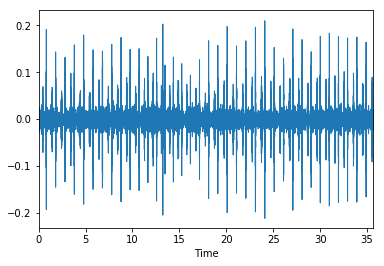

In [8]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure()
librosa.display.waveplot(y, sr=44100)

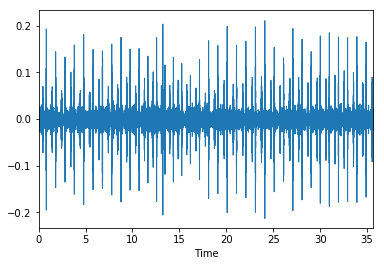

In [9]:
plt.figure()
librosa.display.waveplot(y_2k, sr=2000)

In [10]:
line_height={'S1':1,'systole':2,'S2':3,'diastole':4}

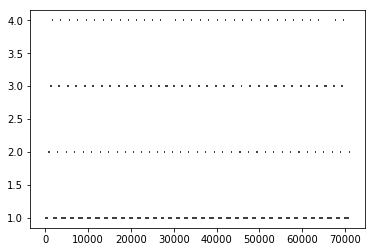

In [11]:
#now try to over lay the line plot that represents segmentation on to audio
row,column=audio_segment.shape
#look at each column and plot a line 
#dict for line height
line_height={'S1':1,'systole':2,'S2':3,'diastole':4}
x_start=0
plt.figure()
for i in range(row):
    x_finish=np.asscalar(audio_segment[i,0]-1) #matlab and python index mismatch
    y=line_height[np.asscalar(audio_segment[i,1][0,0])]
    plt.hlines(y, x_start, x_finish)
    x_start=x_finish
    
#audio_segment

In [12]:
#locate the start of a heart sound - how many 5 cycles does this sample contain from start to finish, from first S1 to last Diastole
#locate the first S1: strip out the label column and find the index for the first S1
groups=[] #keep track of the arrays of groups here
labels=audio_segment[:,1]
indexes=audio_segment[:,0]-1 #python matlab mismatch
#can trust the system lable sequencing is correct (no mechanism of missing a label in HMM)
#find all the s1 locations in the labels and their corresponding indexes and store their corresponding indexed in data points in groups
#only keep the label values
n=len(labels)
label_value=[]
seg_index=[]
for i in range(n):
    individual_label=np.asscalar(labels[i][0,0])
    label_value.append(individual_label)
    individual_index=np.asscalar(indexes[i])
    seg_index.append(individual_index)



In [13]:
indices_s1 = [i for i, x in enumerate(label_value) if x == "S1"]
#check if last indices is out of range - last_index+5>len(list_of_index)
if indices_s1[-1]+5>len(label_value):
    del indices_s1[-1]
#now we are ready to fill the groups
for index in indices_s1:
    subgroup=[seg_index[index],seg_index[index+1],seg_index[index+2],seg_index[index+3],seg_index[index+4]]
    groups.append(subgroup)

In [14]:
len(groups)//5
#there are 7 examples we can construct from this one example
#don't really know the nature of the recording so throw away the tail subgroups seems reasonable 

7

In [15]:
groups

[[678, 958, 1478, 1678, 2718],
 [2718, 2998, 3478, 3678, 4718],
 [4718, 4958, 5478, 5678, 6678],
 [6678, 6918, 7438, 7638, 8678],
 [8678, 8958, 9438, 9638, 10718],
 [10718, 10998, 11438, 11638, 12678],
 [12678, 12918, 13438, 13638, 14678],
 [14678, 14958, 15438, 15638, 16678],
 [16678, 16918, 17398, 17638, 18598],
 [18598, 18838, 19318, 19558, 20518],
 [20518, 20758, 21238, 21438, 22398],
 [22398, 22638, 23118, 23318, 24198],
 [24198, 24478, 24958, 25198, 26038],
 [26038, 26278, 26758, 26958, 27798],
 [27798, 28038, 28558, 28758, 29598],
 [29598, 29878, 30358, 30558, 31478],
 [31478, 31718, 32198, 32398, 33398],
 [33398, 33638, 34118, 34318, 35318],
 [35318, 35558, 36038, 36278, 37318],
 [37318, 37558, 38038, 38238, 39278],
 [39278, 39558, 39998, 40238, 41278],
 [41278, 41518, 41998, 42198, 43318],
 [43318, 43558, 43998, 44198, 45318],
 [45318, 45598, 46038, 46278, 47318],
 [47318, 47598, 48038, 48278, 49318],
 [49318, 49558, 50038, 50278, 51278],
 [51278, 51558, 52038, 52278, 53278],


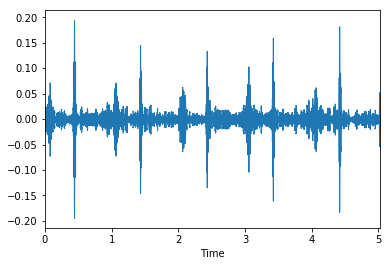

In [16]:
#substract 5 cycles and heartbeat to visualise
#pick first five groups
cycle_to_viz=groups[0]+groups[1]+groups[2]+groups[3]+groups[4]
t_start=cycle_to_viz[0]
t_end=cycle_to_viz[-1]
plt.figure()
librosa.display.waveplot(y_2k[t_start:t_end], sr=2000) 
#now the sequence is ordered - 1 is S1, 2 is Systole etc.


In [17]:
#generate a 1d data series to visulize with wave plot
annotations=np.zeros(len(y_2k[t_start:t_end]))
shifted=np.array(np.unique(cycle_to_viz))-t_start
shitfted_nostart=shifted[1:]
counter=0
previous_index=0
for i in range(len(shitfted_nostart)):
    level=i%4 #s1=0 systole=1 s2=2 diastole=3
    annotations[previous_index:shitfted_nostart[i]]=level
    previous_index=shitfted_nostart[i]
print(annotations)

[0. 0. 0. ... 3. 3. 3.]


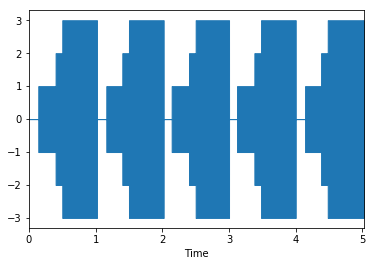

In [18]:
librosa.display.waveplot(annotations, sr=2000) 

In [19]:
#now we know how to extract 5 segments
segment_5cycle=y_2k[t_start:t_end]

In [20]:
#MFCCs from 25ms of thewindow with a step size of 10ms
MFCC=librosa.feature.mfcc(y=segment_5cycle, sr=2000, S=None, n_mfcc=13, dct_type=2, norm='ortho')

In [34]:
from python_speech_features import mfcc
mfcc_coeff = mfcc(segment_5cycle,2000,winlen=0.025, winstep=0.01)

In [22]:
mfcc_coeff.shape

(501, 13)

In [23]:
#try to compute another mfcc_coeff to see if shape is the same

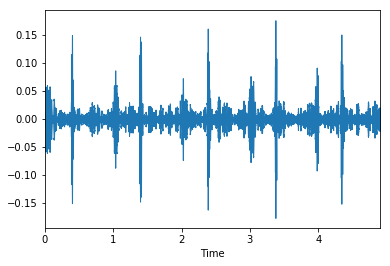

In [24]:
cycle_to_viz1=groups[5]+groups[6]+groups[7]+groups[8]+groups[9]
t_start1=cycle_to_viz1[0]
t_end1=cycle_to_viz1[-1]
librosa.display.waveplot(y_2k[t_start1:t_end1], sr=2000) 

In [25]:
segment_5cycle1=y_2k[t_start1:t_end1]

In [33]:
mfcc_coeff1 = mfcc(segment_5cycle1,2000,winlen=0.025, winstep=0.01)

In [27]:
x,y=mfcc_coeff.shape
x1,y1=mfcc_coeff1.shape

In [49]:
x

501

In [28]:
#input to LSTM model is  (batch_size, timesteps, input_dim)
#corresponding to MFCC coeffceint of one (1,total number of windows,13 coefficents)
#we will need padding for this
#mfcc_coeff=mfcc_coeff.reshape((1, x, y))
#mfcc_coeff1=mfcc_coeff1.reshape((1, x1, y1))

In [43]:
from keras.preprocessing.sequence import pad_sequences
# define sequences
sequences = [mfcc_coeff,mfcc_coeff1]
# pad sequence
padded = pad_sequences(sequences, padding='post',dtype='float64')

In [44]:
padded.shape

(2, 501, 13)

In [45]:
#these two are both normal heart sound
y=np.array([[1,0],[1,0]])

In [46]:
y.shape

(2, 2)

In [55]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
model = Sequential()
#use 20 memeory cell for now
model.add(LSTM(20,input_shape=(None,13)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
model.fit(padded, y, epochs=10, batch_size=1)

Epoch 1/10
2/2 [==============================] - 3s 2s/step - loss: 0.3287 - acc: 1.0000
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.3119 - acc: 1.0000
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.2909 - acc: 1.0000
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.2791 - acc: 1.0000
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.2564 - acc: 1.0000
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.2398 - acc: 1.0000
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 0.2236 - acc: 1.0000
Epoch 8/10
2/2 [==============================] - 4s 2s/step - loss: 0.2142 - acc: 1.0000
Epoch 9/10
2/2 [==============================] - 4s 2s/step - loss: 0.1984 - acc: 1.0000
Epoch 10/10
2/2 [==============================] - 4s 2s/step - loss: 0.1779 - acc: 1.0000


In [62]:
mfcc_coeff_test=mfcc_coeff1.reshape(1,x1,y1)
model.predict(mfcc_coeff_test)

array([[0.7265844 , 0.27341563]], dtype=float32)

In [60]:
#use padding for now (pad 0s) and need to aggreagate the audio samples and labels for training now 
#use memory cell value of 512 it is unclear what is the trick of selecting a good LSTM

In [63]:
#train val split have the data of equal distribution in terms of normal and abnormal and also split up the patients recordins as well
#not all abnormal or normal recordings should come from the same patient for example